In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import get_data
import statsmodels
from simulate import cholesky
from simulate import simulatedata
from simulate import simulate_multiple_time_series

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
syms = ['BTCUSDT']
freq = '10min'
start_date = '2020-01-01'
end_date = '2020-01-03'

In [4]:
raw_data = get_data.get_data(syms, freq, start_date, end_date)
raw_data

BTCUSDT_2019-12-26.json
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=695704595703-1kpq4gcdb9769asd1vhdo80fssdia4m6.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
BTCUSDT_2020-01-02.json


e:\trade\crypto\Binance\get_data.py:52: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data[symbol] = _fit_data_to_df(data[symbol], frequency)[start_time:end_time]


{'BTCUSDT':                               open     high      low    close      volume  \
 time                                                                        
 2020-01-01 00:00:00+00:00  7195.24  7196.25  7178.20  7191.07  154.874358   
 2020-01-01 00:10:00+00:00  7193.15  7193.53  7177.35  7178.29   80.261439   
 2020-01-01 00:20:00+00:00  7177.71  7185.56  7175.47  7178.45   96.049725   
 2020-01-01 00:30:00+00:00  7178.19  7185.44  7176.23  7177.53   59.973326   
 2020-01-01 00:40:00+00:00  7177.14  7182.99  7176.34  7182.94   44.872982   
 ...                            ...      ...      ...      ...         ...   
 2020-01-02 23:20:00+00:00  6959.16  6962.39  6950.00  6962.34  217.262815   
 2020-01-02 23:30:00+00:00  6962.47  6974.75  6957.66  6965.37  145.757951   
 2020-01-02 23:40:00+00:00  6965.09  6969.46  6959.87  6967.41   75.157310   
 2020-01-02 23:50:00+00:00  6967.40  6968.82  6961.24  6965.71   82.459841   
 2020-01-03 00:00:00+00:00  6965.49  6965.71  6948.45

In [5]:
dt = pd.DataFrame()
dt['close'] = raw_data['BTCUSDT']['close']
dt['high'] = raw_data['BTCUSDT']['high']
dt['low'] = raw_data['BTCUSDT']['low']
dt['open'] = raw_data['BTCUSDT']['open']
dt.iloc[150]

close    7202.09
high     7211.16
low      7201.58
open     7211.04
Name: 2020-01-02 01:00:00+00:00, dtype: float64

In [6]:
dt1 = pd.DataFrame()
dt1['close'] = dt['close'].pct_change()
dt1['open'] = dt['open'].pct_change()
dt1

,close,open
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.001777,-0.000290
2020-01-01 00:20:00+00:00,0.000022,-0.002146
2020-01-01 00:30:00+00:00,-0.000128,0.000067
2020-01-01 00:40:00+00:00,0.000754,-0.000146
...,...,...
2020-01-02 23:20:00+00:00,0.000457,-0.001664
2020-01-02 23:30:00+00:00,0.000435,0.000476
2020-01-02 23:40:00+00:00,0.000293,0.000376


In [7]:
#cách 1
#Nhân chol 1 lần
chol = cholesky.cholesky2(dt) 
inverse_chol = np.linalg.inv(chol)
chol

array([[ 1.        ,  0.        ],
       [-0.09305344,  0.99566112]])

In [8]:
order_close, seasonal_order_close = simulatedata.get_order(dt1['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(dt1['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(dt1['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(dt1['open'][1:], order_open, seasonal_order_open)
t_close = simulatedata.simulate_sarima(dt1['close'][1:], order_close, seasonal_order_close, model_params_close, len(dt1), 1)
t_open = simulatedata.simulate_sarima(dt1['open'][1:], order_open, seasonal_order_open, model_params_open, len(dt1), 1)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
dt2 = pd.DataFrame()
dt2['close'] = t_close
dt2['open'] = t_open
dt2
dt3 = simulate_multiple_time_series.normalize_or_standardize_data(dt2['open'], is_normalize= False)
dt4 = simulate_multiple_time_series.normalize_or_standardize_data(dt2['close'], is_normalize= False)
dt3 = np.append(dt3, dt4)
dt3 = np.reshape(dt3, (2, len(dt4)))
dt3

array([[-2.92417752e-01,  5.56679747e-01,  1.80148329e+00,
        -1.77113672e+00, -7.40458587e-01, -1.24088820e+00,
        -2.09415730e+00, -1.35272392e+00, -9.13425721e-01,
        -3.78892462e-01,  1.97269175e+00,  1.39205964e-01,
         1.32573470e+00, -9.66906615e-01, -8.19121870e-01,
        -1.62142142e-01,  2.43593761e+00,  1.56028774e+00,
         1.91010887e-01, -6.51347533e-02, -1.75717245e-01,
         1.50958079e+00,  1.63059920e+00, -6.38618564e-01,
        -6.58155386e-01,  4.90927217e-01,  2.42076286e-01,
         2.50020428e-02,  1.63586358e+00, -3.54575856e-01,
         2.83226624e-01, -8.82833636e-01,  6.54869016e-01,
        -1.15407044e-01, -9.09211921e-01,  7.40860719e-01,
        -4.80247013e-01,  8.56050542e-01, -3.40807977e-01,
        -1.37861371e+00, -8.36568301e-01, -1.69860581e+00,
         1.38196902e+00, -7.01053820e-01, -5.14339073e-01,
         5.82488876e-01, -2.47263880e-01,  1.65012096e+00,
        -1.76767194e-01,  7.92798314e-01,  1.08176958e+0

In [10]:
dt3 = np.matmul(inverse_chol , dt3)
dt3[0], dt3[1]

(array([-0.29241775,  0.55667975,  1.80148329, -1.77113672, -0.74045859,
        -1.2408882 , -2.0941573 , -1.35272392, -0.91342572, -0.37889246,
         1.97269175,  0.13920596,  1.3257347 , -0.96690661, -0.81912187,
        -0.16214214,  2.43593761,  1.56028774,  0.19101089, -0.06513475,
        -0.17571725,  1.50958079,  1.6305992 , -0.63861856, -0.65815539,
         0.49092722,  0.24207629,  0.02500204,  1.63586358, -0.35457586,
         0.28322662, -0.88283364,  0.65486902, -0.11540704, -0.90921192,
         0.74086072, -0.48024701,  0.85605054, -0.34080798, -1.37861371,
        -0.8365683 , -1.69860581,  1.38196902, -0.70105382, -0.51433907,
         0.58248888, -0.24726388,  1.65012096, -0.17676719,  0.79279831,
         1.08176958,  0.59535499, -0.98876574, -0.34286552,  0.37773583,
        -1.26984088,  0.85920005, -0.10912289,  0.53695751,  0.03040914,
         0.00292364, -1.09481412, -0.351386  , -1.99452035,  0.39039185,
        -1.90022849,  0.5462722 , -1.34247014,  1.1

In [11]:
var_close = simulate_multiple_time_series.compute_std(dt2['close'])
mean_close = dt2['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt2['open'])
mean_open = dt2['open'].mean()
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = dt3[1]
transform_x_chol['open'] = dt3[0]
transform_back = pd.DataFrame()
transform_back['open'] = dt3[0] * var_open + mean_open
transform_back['close'] = dt3[0] * var_close + mean_close
# transform_back['open'] = simulate_multiple_time_series.mulback_cholesky(transform_x_chol['open'],  False, var_open, mean_open)
# transform_back['close'] = simulate_multiple_time_series.mulback_cholesky(transform_x_chol['close'],  False, var_close, mean_close)
transform_back 

,open,close
0,-0.000598,-0.000550
1,0.000634,0.000592
2,0.002441,0.002268
3,-0.002745,-0.002541
4,-0.001249,-0.001153
...,...,...
284,-0.001490,-0.001377
285,0.001086,0.001012
286,0.000930,0.000867
287,-0.000209,-0.000189


In [12]:
simulated_price_data = pd.DataFrame()
simulated_price_data['close'] = simulatedata.construct_price_series(transform_back['close'], dt['close'][0], dt.index[0], freq)
simulated_price_data['open'] = simulatedata.construct_price_series(transform_back['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data

,close,open
2020-01-01 00:00:00+00:00,7191.070000,7195.240000
2020-01-01 00:10:00+00:00,7187.112262,7190.935379
2020-01-01 00:20:00+00:00,7191.370346,7195.496110
2020-01-01 00:30:00+00:00,7207.679544,7213.061080
2020-01-01 00:40:00+00:00,7189.367520,7193.263620
...,...,...
2020-01-02 23:20:00+00:00,6875.885482,6846.403127
2020-01-02 23:30:00+00:00,6866.415421,6836.201610
2020-01-02 23:40:00+00:00,6873.362961,6843.629063
2020-01-02 23:50:00+00:00,6879.319590,6849.993006


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


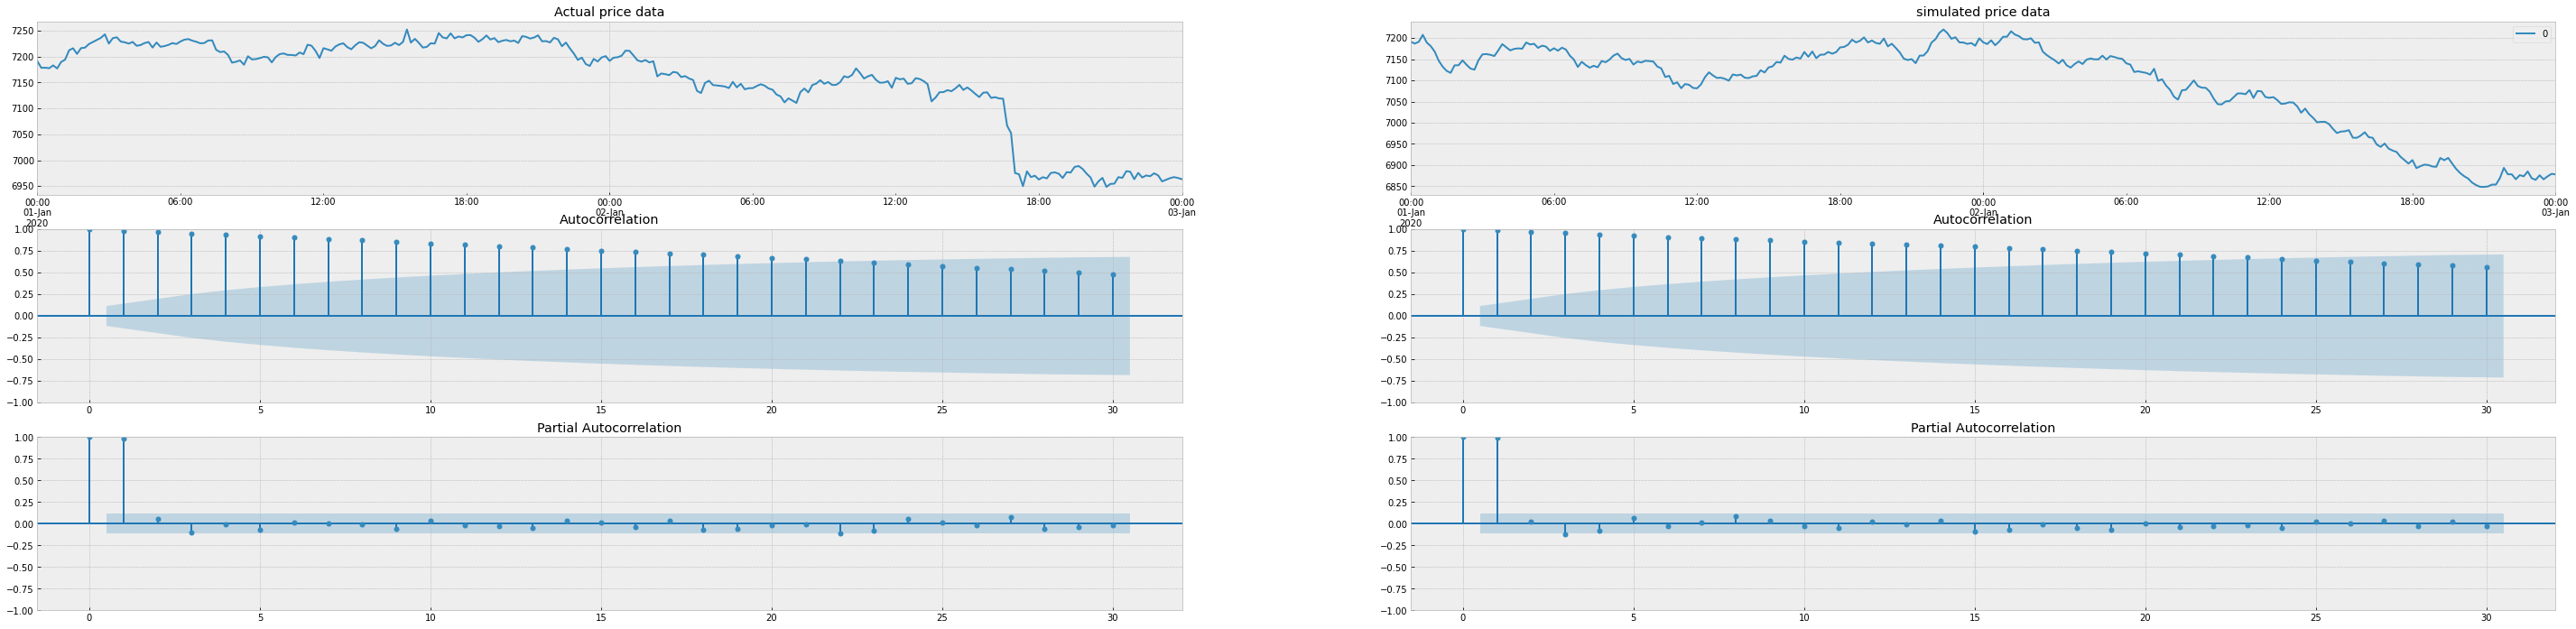

In [14]:
simulate = pd.DataFrame()
simulate[0] = simulated_price_data['close']
simulatedata.Evaluate_performance(dt['close'], simulate, lags=30, isclose = True)

In [ ]:
#cách 2
# nhân chol 2 lần
var_close = simulate_multiple_time_series.compute_std(dt1['close'])
mean_close = dt1['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt1['open'])
mean_open = dt1['open'].mean()
chol = cholesky.cholesky2(dt)
inverse_chol = np.linalg.inv(chol)
# transform = dt1
# transform
transform= simulate_multiple_time_series.transform_forward(dt1, inverse_chol)
transform

In [ ]:
order_close, seasonal_order_close = simulatedata.get_order(transform['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(transform['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open

In [ ]:
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(transform['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(transform['open'][1:], order_open, seasonal_order_open)

In [ ]:
t_close = simulatedata.simulate_sarima(transform['close'][1:], order_close, seasonal_order_close, model_params_close, len(dt1), 1)
t_open = simulatedata.simulate_sarima(transform['open'][1:], order_open, seasonal_order_open, model_params_open, len(dt1), 1)

In [ ]:
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = t_close[0]
transform_x_chol['open'] = t_open[0]
transform_back = simulate_multiple_time_series.transform_back(transform_x_chol, chol, var_close, mean_close, var_open, mean_open)
transform_back

In [ ]:
simulated_price_data = pd.DataFrame()
simulated_price_data[0] = simulatedata.construct_price_series(transform_back['close'], dt['close'][0], dt.index[0], freq)
simulated_price_data[1] = simulatedata.construct_price_series(transform_back['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data

In [ ]:
simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)

In [ ]:
simulate_multiple_time_series.simulate_open_and_close(dt)

In [ ]:
# order, seasonal_order = simulatedata.get_order(dt['open'][1:])
# order, seasonal_order

In [ ]:
# if sum(seasonal_order) == 1: seasonal_order = (0, 0, 0, 0)
# model_params = simulatedata.fit_sarima(dt['open'][1:], order, seasonal_order)

In [ ]:
# t = simulatedata.simulate_sarima(dt['open'][1:], order, seasonal_order, model_params, len(dt), 10)
# t

In [ ]:
# simulated_price_data = simulatedata.construct_price_series(t, dt['close'][0], dt.index[0], freq)

In [ ]:
# simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)